<a href="https://colab.research.google.com/github/shivamsonawane/Sentiment-Clustering/blob/main/Keyword_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keyword Analysis

## Import Libraries

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pickle
import spacy
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt



%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
nltk.download('stopwords')
nltk.download('wordnet')
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# set project directory
os.chdir("/content/drive/MyDrive/Sentiment_Project")

# get all stop words 
stop_words = stopwords.words('english')
print(len(stop_words))

# extend stopwords
file = open("DATA/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()
print(len(stop_words))

179
1527


## Import Data

In [ ]:
# read data
df1 = pd.read_excel("DATA/ukraine_tweets_sample_copy1.xlsx")
df2 = pd.read_excel("DATA/ukraine_tweets_sample_copy2.xlsx")
df3 = pd.read_excel("DATA/ukraine_tweets_sample_copy3.xlsx")

# concat all data files and remove irrelevent label
df = pd.concat([df1, df2, df3], axis=0)
df = df[df["Stance Label"]!="Irrelevant"].reset_index(drop=True)
print(df.shape)
df.head(10)

(4177, 4)


,id_str,created_at,full_text,Stance Label
0,1497026099494023173,2022-02-25 01:50:10,"Russian Rosgvardia troops, likely spetsnaz, cr...",Neutral
1,1497258644987002880,2022-02-25 17:14:13,@WrestlingWombat @HStefansonMB What is happeni...,ProUkraine
2,1497872993732628484,2022-02-27 09:55:25,Today on the campaign trail I had some tough c...,ProUkraine
3,1499163764951818241,2022-03-02 23:24:29,"ICYMI: n light of Russia sanctions, Fed chair ...",Neutral
4,1499467511087222789,2022-03-03 19:31:28,By now over a thousand refugees from #Ukraine ...,ProUkraine
5,1508139059427819522,2022-03-27 17:49:06,Whoever is coming up with reactive strategy by...,ProRussia
6,1508675556358774786,2022-03-29 05:20:57,He also writes about the possibility of Ukrain...,ProUkraine
7,1512504441324322834,2022-04-08 18:55:34,"At Horizon, we are deeply concerned and sadden...",ProUkraine
8,1515578470755192837,2022-04-17 06:30:40,#UkraineUnderAttack Join us in this Democracy ...,ProUkraine
9,1516846493637951489,2022-04-20 18:29:20,@RALee85 Russian tanks in cities where they’re...,ProUkraine


## Data Cleaning

In [ ]:
text = df["full_text"].values.tolist()

In [ ]:
text_step1 = []

for i in range(0, len(text)):
    review = re.sub("\d+", "", str(text[i]))
    text_step1.append(review)
text = text_step1  # re-assigning
del text_step1

In [ ]:
text_step2 = []

for i in range(0, len(text)):
    review = re.sub(r"\W", " ", str(text[i]))
    review = review.lower()
    review = re.sub(r"\s+[a-z]\s+", " ", review)
    review = re.sub(r"^[a-z]\s+", " ", review)
    review = re.sub(r"\d+", " ", review)
    review = re.sub(r"\s+", " ", review)
    text_step2.append(review)

text = text_step2  # re-assigning
del text_step2

In [ ]:
text_step3 = []

for i in text:
    review = gensim.utils.simple_preprocess(str(i), deacc=True)
    text_step3.append(review)

text = text_step3
del text_step3

In [ ]:
text_step4 = []

for i in text:
    ii = []
    for word in i:
        if word not in stop_words:
            ii.append(word)
    text_step4.append(ii)

text = text_step4
del text_step4

In [ ]:
# bigram = gensim.models.Phrases(text, min_count=5, threshold=100)
# bigram_mod = gensim.models.phrases.Phraser(bigram)

# text_step5 = []

# for i in text:
#     text_step5.append(bigram_mod[i])

# text = text_step5
# del text_step5


In [ ]:
# trigram = gensim.models.Phrases(bigram[text], threshold=100)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# text_step6 = []

# for i in text:
#     text_step6.append(trigram_mod[bigram_mod[i]])

# text = text_step6
# del text_step6

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
nlp.max_length = (
    3000000  # increasing text length to 3000000 from default of 1000000
)
allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]

text_step7 = []

for i in text:
    doc = nlp(" ".join(i))
    text_step7.append(
        [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    )

text = text_step7
del text_step7

In [ ]:
text_step8 = []

for i in text:
    ii = []
    for word in i:
        if word not in stop_words:
            ii.append(word)
    text_step8.append(ii)

text = text_step8
del text_step8

In [ ]:
id2word = corpora.Dictionary(text)
corpus = []
for i in text:
    d = id2word.doc2bow(i)
    corpus.append(d)

In [ ]:
text_join = []

for i in text:
    word = " ".join(i)
    text_join.append(word)

df["clean"] = text_join

In [ ]:
df.head()

,id_str,created_at,full_text,Stance Label,clean
0,1497026099494023173,2022-02-25 01:50:10,"Russian Rosgvardia troops, likely spetsnaz, cr...",Neutral,russian rosgvardia troop spetsnaz cross plheqwvq
1,1497258644987002880,2022-02-25 17:14:13,@WrestlingWombat @HStefansonMB What is happeni...,ProUkraine,happen accept time fear stand defend innocent ...
2,1497872993732628484,2022-02-27 09:55:25,Today on the campaign trail I had some tough c...,ProUkraine,campaign trail tough conversation people vacci...
3,1499163764951818241,2022-03-02 23:24:29,"ICYMI: n light of Russia sanctions, Fed chair ...",Neutral,icymi call legislative framework illicit
4,1499467511087222789,2022-03-03 19:31:28,By now over a thousand refugees from #Ukraine ...,ProUkraine,refugee reach include child greet kid soft toy...


## Unigram 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# frequency
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer()
    
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


In [ ]:
common_words = get_top_n_words(df["clean"], n=100)
df1 = pd.DataFrame(common_words, columns=["Text", "count"])
df1.head(10)

,Text,count
0,ukrainian,596
1,ukraine,487
2,russian,480
3,https,397
4,people,396
5,war,395
6,propaganda,250
7,country,240
8,support,223
9,nazi,200


In [ ]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)


In [ ]:
plt1 = (
                        df1.groupby("Text")
                        .sum()["count"]
                        .sort_values(ascending=False)
                        .iplot(
                            kind="bar",
                            yTitle="Count",
                            linecolor="black",
                            title="Top 100 words after removing stop words",
                            asFigure=True # plotly obj needs to be returned for streamlit to interpret
                        )
                    )
plt1
plt1.show(renderer="colab")

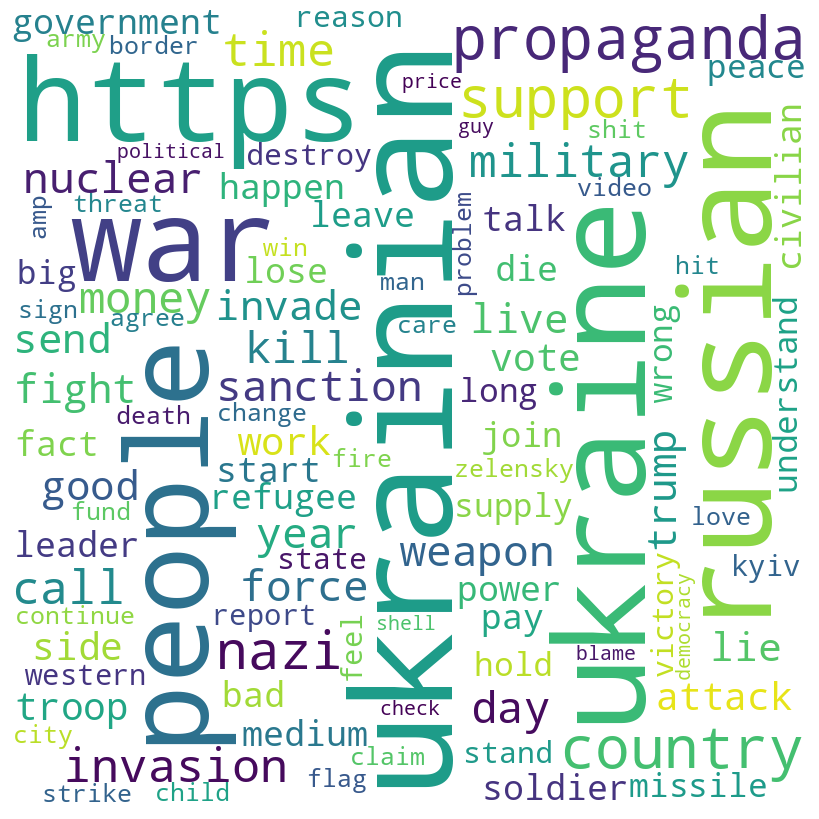

In [ ]:
# create dictionary with text as key and count as value
word_dict = dict(zip(df1['Text'], df1['count']))

# create wordcloud object
wordcloud = WordCloud(width = 800, 
                      height = 800, 
                      background_color ='white', 
                      max_words=100,
                      colormap='viridis').generate_from_frequencies(word_dict)

# plot the wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# show the plot
plt.show()

## Bigram

In [ ]:
#bigram

def get_top_n_bigram(corpus, n=None):
    
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df["clean"], 100)
df2 = pd.DataFrame(common_words, columns=["Text", "count"])
df2.head(10)

,Text,count
0,nuclear weapon,34
1,russian force,29
2,nuclear power,26
3,war crime,24
4,power plant,23
5,ukraine war,20
6,ukrainian refugee,20
7,nuclear war,19
8,people ukraine,18
9,support ukrainian,18


In [ ]:
plt2 = (
                        df2.groupby("Text")
                        .sum()["count"]
                        .sort_values(ascending=False)
                        .iplot(
                            kind="bar",
                            yTitle="Count",
                            linecolor="black",
                            title="Top 100 bigrams after removing stop words",
                            asFigure=True # plotly obj needs to be returned for streamlit to interpret
                        )
                    )
plt2.show(renderer="colab")

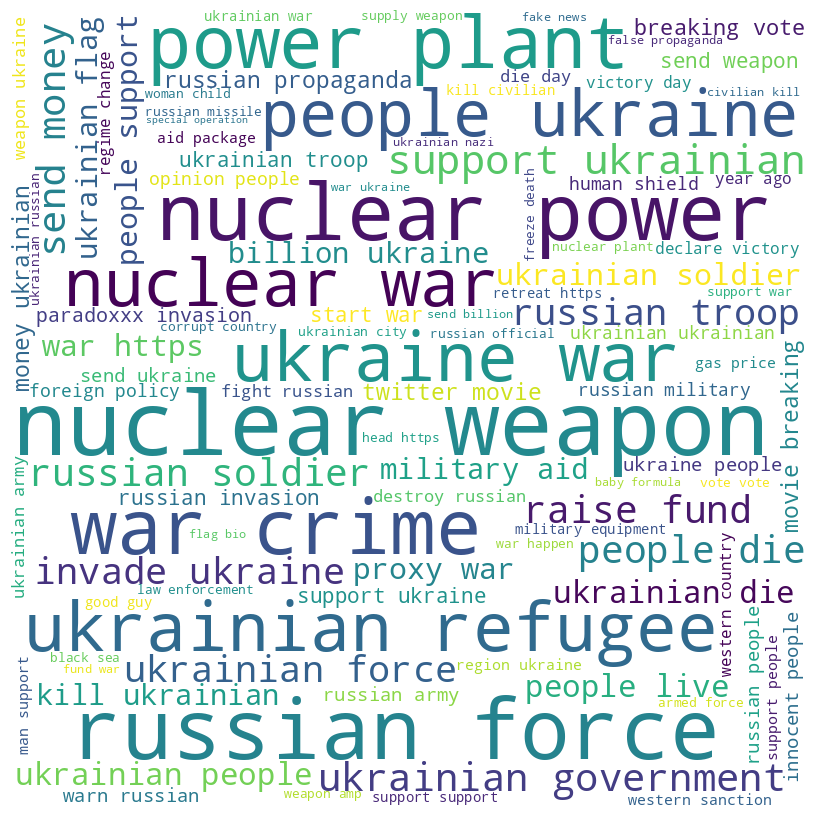

In [ ]:
# create dictionary with text as key and count as value
word_dict = dict(zip(df2['Text'], df2['count']))

# create wordcloud object
wordcloud = WordCloud(width = 800, 
                      height = 800, 
                      background_color ='white', 
                      max_words=100,
                      colormap='viridis').generate_from_frequencies(word_dict)

# plot the wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# show the plot
plt.show()

## Trigram

In [ ]:
#trigram

def get_top_n_trigram(corpus, n=None):
    
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df["clean"], 100)
df3 = pd.DataFrame(common_words, columns=["Text", "count"])
df3.head(10)

,Text,count
0,nuclear power plant,21
1,twitter movie breaking,13
2,movie breaking vote,13
3,military aid package,8
4,civilian human shield,6
5,zelensky demand zelensky,6
6,charitable project support,6
7,project support people,6
8,support people animal,6
9,people animal suffer,6


In [ ]:
plt3 = (
                        df3.groupby("Text")
                        .sum()["count"]
                        .sort_values(ascending=False)
                        .iplot(
                            kind="bar",
                            yTitle="Count",
                            linecolor="black",
                            title="Top 100 Trigram after removing stop words",
                            asFigure=True # plotly obj needs to be returned for streamlit to interpret
                        )
                    )

plt3.show(renderer="colab")

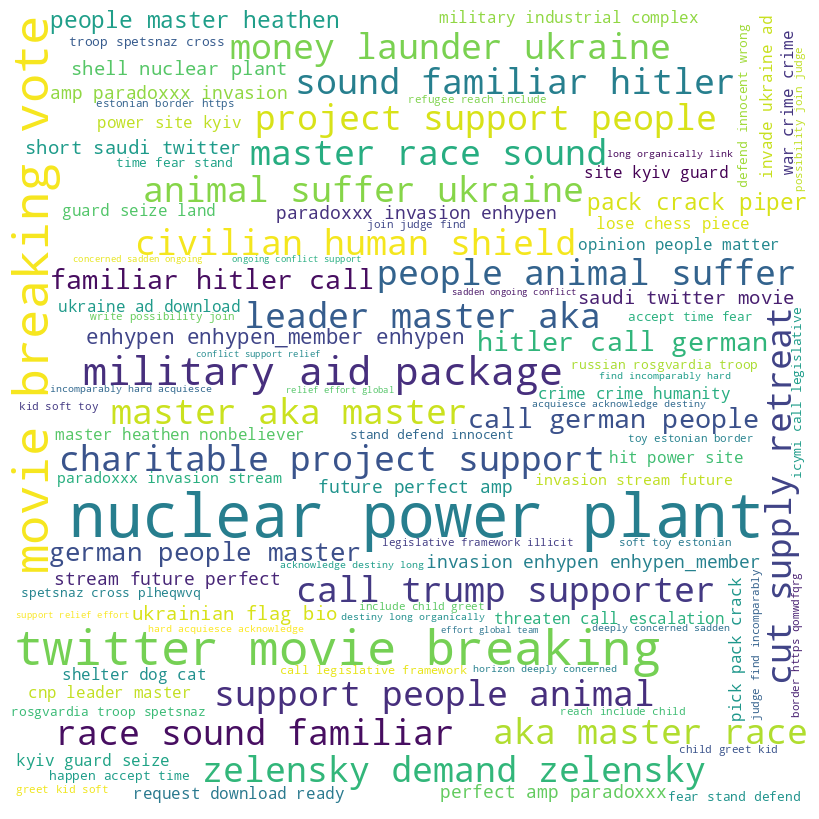

In [ ]:

# create dictionary with text as key and count as value
word_dict = dict(zip(df3['Text'], df3['count']))

# create wordcloud object
wordcloud = WordCloud(width = 800, 
                      height = 800, 
                      background_color ='white', 
                      max_words=100,
                      colormap='viridis').generate_from_frequencies(word_dict)

# plot the wordcloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# show the plot
plt.show()
